<a href="http://agrum.org" target="blank"><img src="http://agrum.gitlab.io/theme/img/logoAgrum.png" align="left" style="height:100px"/></a><a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This pyAgrum's notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

In [1]:
import os 

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

# Generating the database from a BN

In [2]:
bn=gum.loadBN(os.path.join("res","asia.bif"))
bn

(gum::BayesNet<double>@0x55b2d34fe6e0) BN{nodes: 8, arcs: 8, domainSize: 256, parameters: 36, compression ratio: 85% }

In [12]:
# we create a quite large database
gum.generateCSV(bn,os.path.join("out","sample_chi2.csv"),500000,False)

-1612846.0152638443

# Testing d-separations using chi2 in the database

In [13]:
# do not forget that the generation process above is random : from time to time, the tests my not be correct...
def isIndep(pvalue):
    return pvalue>=0.05

def testIndepFromChi2(learner,var1,var2,kno=[]):
    """
    Just prints the resultat of the chi2
    """
    stat,pvalue=learner.chi2(var1,var2,kno)
    if len(kno)==0:
        print("From Chi2 tests, is '{}' indep from '{}' ==> {}".format(var1,var2,isIndep(pvalue)))
    else:
        print("From Chi2 tests, is '{}' indep from '{}' given {} : {}".format(var1,var2,kno,isIndep(pvalue)))
    
learner=gum.BNLearner(os.path.join("out","sample_chi2.csv"))

testIndepFromChi2(learner,"visit_to_Asia?","smoking?")
testIndepFromChi2(learner,"visit_to_Asia?","smoking?",['tuberculos_or_cancer?'])
testIndepFromChi2(learner,"visit_to_Asia?","smoking?",['positive_XraY?'])
testIndepFromChi2(learner,"dyspnoea?","smoking?")
testIndepFromChi2(learner,"dyspnoea?","smoking?",["lung_cancer?","bronchitis?"])


From Chi2 tests, is 'visit_to_Asia?' indep from 'smoking?' ==> True
From Chi2 tests, is 'visit_to_Asia?' indep from 'smoking?' given ['tuberculos_or_cancer?'] : False
From Chi2 tests, is 'visit_to_Asia?' indep from 'smoking?' given ['positive_XraY?'] : False
From Chi2 tests, is 'dyspnoea?' indep from 'smoking?' ==> False
From Chi2 tests, is 'dyspnoea?' indep from 'smoking?' given ['lung_cancer?', 'bronchitis?'] : True


# Evolution of p-values w.r.t the size of the database (in Asia)

In [29]:
def consolidationIndepFromChi2(bn,size,lindep,nbr=20):
    """
    Using $nbr$ generated databases of size $size$ from the bn $bn$, 
    consolidate the p-value for a list $lindep$ of conditional independence to test.
    
    return the list of consolidated pValues
    """
    pvalue_cumul=[0.0]*len(lindep)
    for i in range(nbr):
        gum.generateCSV(bn,os.path.join("out","sample_chi2.csv"),size,False)
        learner=gum.BNLearner(os.path.join("out","sample_chi2.csv"))
        for i,(var1,var2,kno) in enumerate(lindep):
            stat,pvalue=learner.chi2(var1,var2,kno)
            pvalue_cumul[i]+=pvalue
    return [p/nbr for p in pvalue_cumul]
    
sizes=[50,100,500,1000,2000,5000,10000,20000,50000,100000,200000]
pvalues1,pvalues2,pvalues3,pvalues4=zip(*[consolidationIndepFromChi2(bn,siz,
                                     [("visit_to_Asia?","smoking?",['tuberculos_or_cancer?']),
                                      ("visit_to_Asia?","smoking?",[]),
                                      ("dyspnoea?","smoking?",[]),
                                      ("dyspnoea?","smoking?",["lung_cancer?","bronchitis?"])])
                                          for siz in sizes])


(gum::BayesNet<double>@0x55b2d3b21d70) BN{nodes: 8, arcs: 8, domainSize: 256, parameters: 36, compression ratio: 85% }

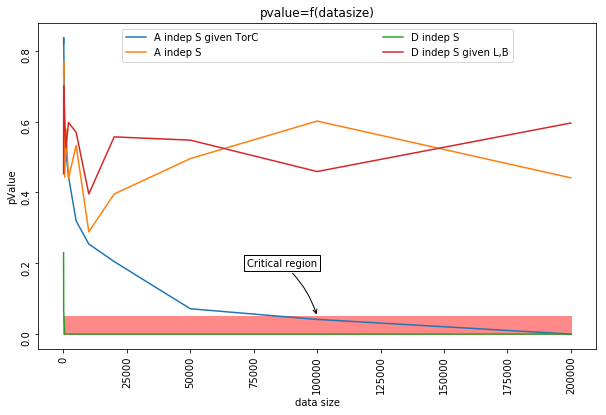

In [6]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig=figure(figsize=(10,6))
ax  = fig.add_subplot(1, 1, 1)

ax.plot(sizes,pvalues1,label="A indep S given TorC")
ax.plot(sizes,pvalues2,label="A indep S")
ax.plot(sizes,pvalues3,label="D indep S")
ax.plot(sizes,pvalues4,label="D indep S given L,B")
ax.tick_params(rotation=90)
ax.set_xlabel("data size")
ax.set_ylabel("pValue")
ax.legend(bbox_to_anchor=(0.15, 0.88, 0.7, .102), loc=3,ncol=2, mode="expand", borderaxespad=0.)

rect = patches.Rectangle((0,0),max(sizes),0.05,linewidth=1,edgecolor='#FF8888',facecolor='#FF8888')
ax.add_patch(rect)
ax.annotate("Critical region",xytext=(100000,0.2),xy=(100000,0.05),
            ha="right", va="center",
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.15"
                           ),
            bbox=dict(boxstyle="square", fc="w"))

ax.set_title("pvalue=f(datasize)");

gum.fastBN("A->T->TorC->X;S->C->TorC->D<-B<-S")